<a href="https://colab.research.google.com/github/MIlhamEr/Skripsi/blob/main/LSTM%20100%2050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [2]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1555.0,1555.0,1490.0,1495.0,835.632202,76612000
1,2020-01-03,1460.0,1470.0,1425.0,1465.0,856.372375,117795600
2,2020-01-06,1455.0,1515.0,1450.0,1465.0,856.372375,61423200
3,2020-01-07,1480.0,1540.0,1460.0,1540.0,900.213867,74336500
4,2020-01-08,1530.0,1535.0,1505.0,1505.0,879.754395,55121100


In [3]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [4]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1360.0,1435.0,1360.0,1435.0,1435.0,5000
1,2020-01-03,1435.0,1435.0,1435.0,1435.0,1435.0,0
2,2020-01-06,1437.5,1437.5,1435.0,1435.0,1435.0,3000
3,2020-01-07,1435.0,1435.0,1435.0,1435.0,1435.0,0
4,2020-01-08,1435.0,1435.0,1435.0,1435.0,1435.0,0


In [5]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Normalisasi Data

*   Normalisasi data adro pake MinMaxScaler karena distribusinya normal
*   Normalisasi data dssa pake StandardScaler karena terdapat outlier
*   Kolom Date Ga dipake

In [6]:
scaler = MinMaxScaler()

In [7]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [8]:
adro_norm = adro.copy()
adro_norm = normalize_data(adro_norm)
adro_norm = adro_norm.drop('Volume', axis=1)
adro_norm.head()

,Open,High,Low,Close,Adj Close
0,0.260372,0.247207,0.253602,0.243205,0.129805
1,0.233190,0.223464,0.234870,0.234621,0.135675
2,0.231760,0.236034,0.242075,0.234621,0.135675
3,0.238913,0.243017,0.244957,0.256080,0.148084
4,0.253219,0.241620,0.257925,0.246066,0.142293


In [9]:
dssa_norm = dssa.copy()
dssa_norm = normalize_data(dssa_norm)
dssa_norm = dssa_norm.drop('Volume', axis=1)
dssa_norm.head()

,Open,High,Low,Close,Adj Close
0,0.010859,0.011743,0.011073,0.012575,0.012575
1,0.012669,0.011743,0.012918,0.012575,0.012575
2,0.012729,0.011800,0.012918,0.012575,0.012575
3,0.012669,0.011743,0.012918,0.012575,0.012575
4,0.012669,0.011743,0.012918,0.012575,0.012575


## Windowing (Time Series Data)

Data look back yaitu adalah data yang biasanya dipakai untuk tipe time series, data ini menjadikan nilai lookback+1 sebagai nilai prediksi , dan data lookbacknya sebagai fitur.Ini berlaku untuk seluruh data, contoh penggambarannya seperti pada gambar diatas

In [10]:
def prepare_data(df, time_step):
    X, y = [], []
    for i in range(len(df)-time_step):
        t = []
        for j in range(time_step):
            t.append(df.iloc[i + j].values)  # Use all columns for features
        X.append(t)
        y.append(df['High'][i + time_step]) # Predict High price
    return np.array(X), np.array(y)

In [11]:
time_step = 7
X_adro, y_adro = prepare_data(adro_norm, time_step)

In [12]:
print(X_adro)
print(y_adro)

[[[0.26037196 0.2472067  0.25360231 0.24320458 0.12980455]
  [0.23319027 0.22346369 0.23487032 0.23462089 0.13567503]
  [0.23175966 0.23603352 0.24207493 0.23462089 0.13567503]
  ...
  [0.25321888 0.24162011 0.25792507 0.24606581 0.14229328]
  [0.25035765 0.23882682 0.24927954 0.24320458 0.14063873]
  [0.25035765 0.25       0.26080692 0.25894134 0.14973887]]

 [[0.23319027 0.22346369 0.23487032 0.23462089 0.13567503]
  [0.23175966 0.23603352 0.24207493 0.23462089 0.13567503]
  [0.23891273 0.24301676 0.24495677 0.25608011 0.1480843 ]
  ...
  [0.25035765 0.23882682 0.24927954 0.24320458 0.14063873]
  [0.25035765 0.25       0.26080692 0.25894134 0.14973887]
  [0.26895565 0.25837989 0.27233429 0.26323319 0.15222076]]

 [[0.23175966 0.23603352 0.24207493 0.23462089 0.13567503]
  [0.23891273 0.24301676 0.24495677 0.25608011 0.1480843 ]
  [0.25321888 0.24162011 0.25792507 0.24606581 0.14229328]
  ...
  [0.25035765 0.25       0.26080692 0.25894134 0.14973887]
  [0.26895565 0.25837989 0.2723342

In [13]:
X_adro.shape, y_adro.shape

((1141, 7, 5), (1141,))

In [14]:
X_dssa, y_dssa = prepare_data(dssa_norm, time_step)

## Split data into training and testing sets

In [15]:
X_train_adro, X_test_adro, y_train_adro, y_test_adro = train_test_split(X_adro, y_adro, test_size=0.2, random_state=42, shuffle=False)
X_train_dssa, X_test_dssa, y_train_dssa, y_test_dssa = train_test_split(X_dssa, y_dssa, test_size=0.2, random_state=42, shuffle=False)

In [16]:
X_train_adro.shape, X_test_adro.shape, y_train_adro.shape, y_test_adro.shape

((912, 7, 5), (229, 7, 5), (912,), (229,))

# Data Mining

In [17]:
def create_lstm_model(units):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_adro.shape[1], X_train_adro.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for single prediction (predicted stock price)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## ADRO

In [18]:
model_adro = create_lstm_model(100)

start_time = time.time()
model_adro.fit(X_train_adro, y_train_adro, epochs=50, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0957 - val_loss: 0.0016
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 8.4848e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - val_loss: 8.1366e-04
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0021 - val_loss: 8.1594e-04
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

In [19]:
model_adro.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 100)              │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 368,705 (1.41 MB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (960.18 KB)

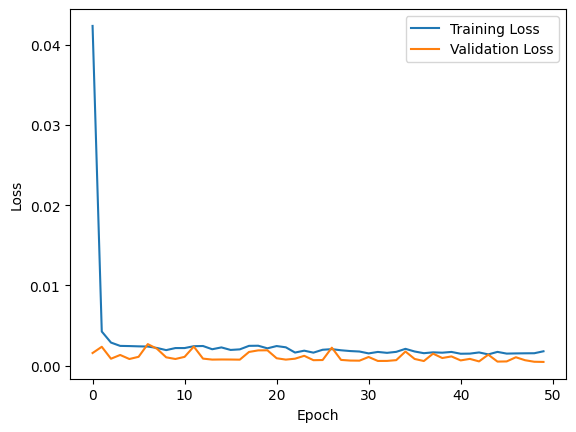

In [20]:
plt.plot(model_adro.history.history['loss'], label='Training Loss')
plt.plot(model_adro.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make predictions

In [21]:
y_pred_adro = model_adro.predict(X_test_adro)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


## DSSA

In [22]:
model_dssa = create_lstm_model(100)

start_time = time.time()
model_dssa.fit(X_train_dssa, y_train_dssa, epochs=50, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 8.8348e-04 - val_loss: 9.3008e-05
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.7335e-05 - val_loss: 2.7254e-05
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.0948e-05 - val_loss: 2.1084e-05
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.3678e-05 - val_loss: 2.1696e-05
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2320e-05 - val_loss: 3.7562e-05
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.8174e-05 - val_loss: 2.0240e-05
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.9093e-05 - val_loss: 1.8776e-05
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4160e-05 - val_loss: 3.1523e-05
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.2711e-05 - val_loss: 3.2884e-05
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4767e-05 - val_loss: 2.5956e-05
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9393e-0

In [23]:
model_dssa.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 7, 100)              │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 368,705 (1.41 MB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (960.18 KB)

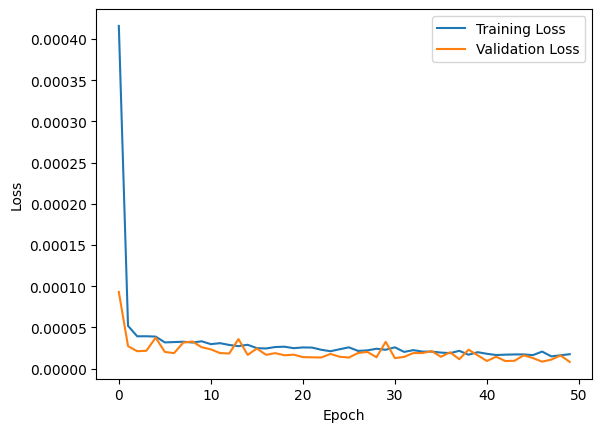

In [24]:
plt.plot(model_dssa.history.history['loss'], label='Training Loss')
plt.plot(model_dssa.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make predictions

In [25]:
y_pred_dssa = model_dssa.predict(X_test_dssa)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


## Evaluate Model

In [26]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R-squared: {r2:.5f}')

    return rmse, mape, r2

In [27]:
# Evaluate ADRO model
print("Evaluation for ADRO:")
rmse_adro, mape_adro, r2_adro = evaluate_model(y_test_adro, y_pred_adro)

# Evaluate DSSA model
print("\nEvaluation for DSSA:")
rmse_dssa, mape_dssa, r2_dssa = evaluate_model(y_test_dssa, y_pred_dssa)

Evaluation for ADRO:
RMSE: 0.022
MAPE: 17.072%
R-squared: 0.95499

Evaluation for DSSA:
RMSE: 0.042
MAPE: 114.962%
R-squared: 0.97843


## Plot the predicted vs actual values

In [28]:
def plot_predictions(y_true, y_pred, title, bgcolor='#f8f4f4', figcolor='#f8f4f4'):
    plt.figure(figsize=(16, 4), facecolor=figcolor)
    ax = plt.gca()
    ax.set_facecolor(bgcolor)

    plt.plot(y_true, label='Actual Price', color='orange')
    plt.plot(y_pred, label='Predicted Price', color='green')

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.gca().set_facecolor(bgcolor)

    plt.show()

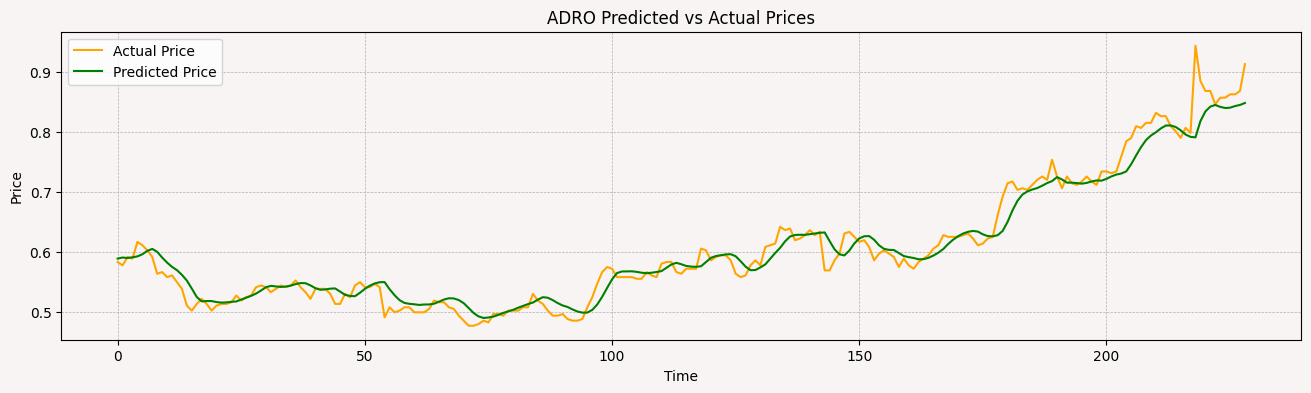

In [29]:
# Plot ADRO predictions
plot_predictions(y_test_adro, y_pred_adro, 'ADRO Predicted vs Actual Prices')

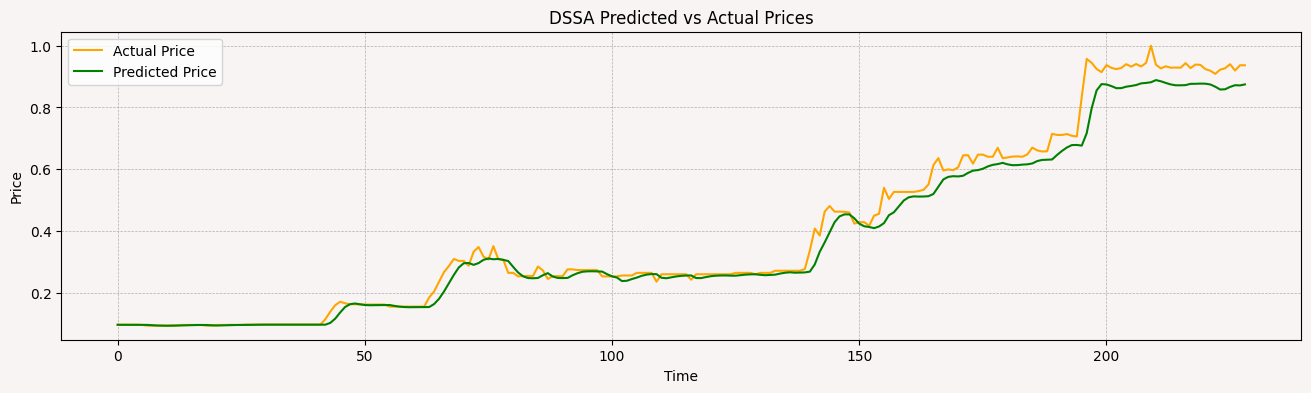

In [30]:
plot_predictions(y_test_dssa, y_pred_dssa, 'DSSA Predicted vs Actual Prices')